In [1]:
SUBMISSION = True

* Object: Single CV: 0.60 and LB 0.56
* reference: https://www.kaggle.com/braquino/convert-to-regression

# Load Library

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random
import numpy as np
import pandas as pd
pd.set_option('max_columns',150)
import seaborn as sns
import matplotlib.pyplot as plt

import gc
import json
import pickle
from collections import Counter

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgbm

import lightgbm as lgb
import xgboost as xgb

# Load Dataset

In [4]:
def load_dataset(submission=False):
    if submission:
        path = '../input/data-science-bowl-2019/'
        train_raw = pd.read_csv(f'{path}train.csv')
        test_raw = pd.read_csv(f'{path}test.csv')
    else:
        path = '../input/sogna-01-dsb-save-data/'
        with open(f'{path}train.pkl', 'rb') as f:
            train_raw = pickle.load(f)
        with open(f'{path}test.pkl', 'rb') as f:
            test_raw = pickle.load(f)
    
    print(f"Train Size: {train_raw.shape[0]}, Test Size: {test_raw.shape[0]}")
    
    # sort values
    '''
    train_raw = train_raw.sort_values(['installation_id', 'timestamp', 'event_count'])
    test_raw = test_raw.sort_values(['installation_id', 'timestamp', 'event_count'])
    '''
    
    # new columns
    train_raw['title_event_code'] = train_raw['title'].astype('str') + '_' + train_raw['event_code'].astype('str')
    test_raw['title_event_code'] = test_raw['title'].astype('str') + '_' + test_raw['event_code'].astype('str')

    train_raw['timestamp'] = pd.to_datetime(train_raw['timestamp'])
    test_raw['timestamp'] = pd.to_datetime(test_raw['timestamp'])
    
    return train_raw, test_raw

In [5]:
train_raw, test_raw = load_dataset(submission=SUBMISSION)
gc.collect()

Train Size: 11341042, Test Size: 1156414


0

# Preprocess

* raw data to processed data

In [6]:
CONTENTS_TYPE = ['Clip', 'Activity', 'Assessment', 'Game']

ASSESSMENT_TITLE = [
    'Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)', 'Cauldron Filler (Assessment)', 
    'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']

GAME_TITLE = [
    'Scrub-A-Dub', 'Dino Drink', 'All Star Sorting', 'Air Show', 'Crystals Rule', 'Bubble Bath', 
    'Dino Dive', 'Chow Time', 'Pan Balance', 'Happy Camel', 'Leaf Leader']

ACTIVITY_TITLE = [
    'Sandcastle Builder (Activity)', 'Watering Hole (Activity)', 'Fireworks (Activity)', 
    'Flower Waterer (Activity)', 'Bug Measurer (Activity)', 'Bottle Filler (Activity)',
    'Chicken Balancer (Activity)', 'Egg Dropper (Activity)']

TITLE_LIST = train_raw['title'].append(test_raw['title']).unique().tolist()
TITLE_EVNET_CODE_LIST = train_raw['title_event_code'].append(test_raw['title_event_code']).unique().tolist()

In [7]:
def get_assess_attempts_cnt(sess_title, game_data):
    if sess_title == "Bird Measurer (Assessment)":
        logit = [json.loads(v)["correct"] for v in game_data[game_data['event_code'] == 4110]['event_data'].values]
    else:
        logit = [json.loads(v)["correct"] for v in game_data[game_data['event_code'] == 4100]['event_data'].values]
    
    true_attempts = np.sum(logit)
    false_attempts = len(logit) - true_attempts
    
    return true_attempts, false_attempts

In [8]:
def get_game_attempts_cnt(sess_title, game_data):
    true_attempts, false_attempts = 0, 0
    event_code_list = game_data['event_code'].values
    
    if sess_title == "All Star Sorting":
        true_attempts = np.count_nonzero(event_code_list == 3021)
        false_attempts = np.count_nonzero(event_code_list == 3020)
        
    elif (sess_title == "Air Show") or (sess_title == "Pan Balance"):
        logit = [json.loads(v)["correct"] for v in game_data[game_data['event_code'] == 4100]['event_data'].values]
        true_attempts = np.sum(logit)
        false_attempts = len(logit) - true_attempts
    
    elif (sess_title == "Chow Time") or (sess_title == "Leaf Leader"):
        true_attempts = np.count_nonzero(event_code_list == 2030)
        logit = [json.loads(v)["misses"] for v in game_data[game_data['event_code'] == 2030]['event_data'].values]
        false_attempts = np.sum(logit)
    
    else:
        logit = [json.loads(v)["correct"] for v in game_data[game_data['event_code'] == 4020]['event_data'].values]
        true_attempts = np.sum(logit)
        false_attempts = len(logit) - true_attempts
    
    return true_attempts, false_attempts

In [9]:
def bird_measurer_l2(game_data):    
    t_att, f_att = 0, 0
    event_code_list = game_data['event_code'].values
        
    stage2_logit = [json.loads(v)["correct"] for v in game_data[game_data['event_code'] == 4100]['event_data'].values]

    # how much correct cnt? 
    t_att = np.sum(stage2_logit)
    
    # how much incorrect cnt? 
    f_att = len(stage2_logit) - t_att

    return t_att, f_att

In [10]:
def get_accuracy_group(accuracy):
    if accuracy == 1:
        return 3
    elif accuracy == 0.5:
        return 2
    elif (accuracy < 0.5) and (accuracy > 0):
        return 1
    elif accuracy == 0:
        return 0
    else:
        return np.nan

In [11]:
def get_feature(data, ins_id, is_test=False):
    
    all_assessments = []
    
    # session cnt, session cnt per type
    sess_cnt, sess_cnt_per_contents = 0, {'sess_cnt_' + k: 0 for k in CONTENTS_TYPE}
    
    # event cnt, event cnt per type
    event_cnt, event_cnt_per_contents = 0, {'event_cnt_' + k: 0 for k in CONTENTS_TYPE}
    
    
    ### assessment related features
    # - is first assessment ?
    first_assess = True
    
    # - is first assessment each title ?
    first_assess_title = {title: True for title in ASSESSMENT_TITLE}
    
    # - accuracy group cnt
    accuracy_group_cnt = {"accuracy_group_" + str(i): 0 for i in range(0, 4)}
    
    # - accuracy group cnt each assess
    accuracy_group_cnt_per_assess = {}
    for assess_title in ASSESSMENT_TITLE:
        for i in range(0, 4):
            accuracy_group_cnt_per_assess[assess_title + '_' + str(i)] = 0

    # - total assessment
    assess_true_attempts = []
    assess_false_attempts = []
    assess_accuracy = []
    assess_accuracy_group = []
    
    # - each assessment
    true_attempts_per_assess = {'true_attempts_' + title: [] for title in ASSESSMENT_TITLE}
    false_attempts_per_assess = {'false_attempts_' + title: [] for title in ASSESSMENT_TITLE}
    accuracy_per_assess = {'acc_' + title: [] for title in ASSESSMENT_TITLE}
    accuracy_group_per_assess = {'acc_group_' + title: [] for title in ASSESSMENT_TITLE} 
    
    ### game related features
    # - total game
    game_true_attempts = []
    game_false_attempts = []
    game_accuracy = []
    
    # - each game
    true_attempts_per_game = {'true_attempts_' + title: [] for title in GAME_TITLE}
    false_attempts_per_game = {'false_attempts_' + title: [] for title in GAME_TITLE}
    accuracy_per_game = {'acc_' + title: [] for title in GAME_TITLE}
    
    ### activity related features
    # - duration
    duration = {f"duration_{title}": [] for title in ACTIVITY_TITLE}
        
    ### Assessment, Game, Activity related features
    # - distraction
    rate_4070 = {f"rate_4070_{title}": [] for title in ASSESSMENT_TITLE + GAME_TITLE + ACTIVITY_TITLE}
    
    ### value count features
    title_cnt = {title: 0 for title in TITLE_LIST}
    title_event_code_cnt = {title_code: 0 for title_code in TITLE_EVNET_CODE_LIST}

    # counter
    counter_ass, counter_per_title_ass = 0, {title: 0 for title in ASSESSMENT_TITLE}
    counter_game, counter_per_title_game = 0, {title: 0 for title in GAME_TITLE}
        
    ### Each title related features
    # - Flower Waterer (Activity)
    flower_waterer_watering_duration = []
    
    # - Bird Measurer (Assessment)
    bird_measurer_l2_true_attempts = []
    bird_measurer_l2_false_attempts = []
    bird_measurer_l2_acc_attempts = []
    
    # on each game_session of one installation_id
    for sess_id, game_session in data.groupby('game_session', sort=False):
        
        sess_type = game_session['type'].values[0]
        sess_title = game_session['title'].values[0]
        sess_world = game_session['world'].values[0]
        
                
        ##### ##### ##### ##### ##### ##
        ##### FEATURE UPDATE FIELD #####
        ## ##### ##### ##### ##### #####
        if sess_type == 'Assessment':
            
            # Target
            t_att, f_att = get_assess_attempts_cnt(sess_title, game_session)
            accuracy = t_att / (t_att + f_att) if (t_att + f_att) != 0 else np.nan
            accuracy_group = get_accuracy_group(accuracy)
            
            if (not np.isnan(accuracy)) or (is_test):
                
                ### Target
                # target features
                features = {'assess_true_attempts': t_att, 
                            'assess_false_attempts': f_att, 
                            'accuracy': accuracy, 
                            "accuracy_group": accuracy_group}
                
                ### Common
                features.update({"installation_id": ins_id})
                features.update({"game_session": sess_id})
                features.update({"sessoin_world": sess_world})
                features.update({"session_title": sess_title})

                # session cnt, session cnt per type
                features.update({"session_cnt": sess_cnt})
                features.update(sess_cnt_per_contents.copy())

                # event cnt, event cnt per type
                features.update({"event_cnt": event_cnt})
                features.update(event_cnt_per_contents.copy())
                
                ### Assessment
                # - first asessment
                features.update({"first_assess": first_assess})
                
                # - first assessment each title
                features.update({"first_assess_title": first_assess_title[sess_title]})
                
                # - accuracy group
                '''
                features.update(accuracy_group_cnt.copy())
                features.update(accuracy_group_cnt_per_assess.copy())
                features.update({f"target_acc_group_{i}": features[f'{sess_title}_{i}'] for i in range(0, 4)})
                '''
                
                # - total assessment
                features.update({"accum_assess_true_attempts": np.sum(assess_true_attempts)})
                features.update({"accum_assess_false_attempts": np.sum(assess_false_attempts)})
                features.update({"mean_assess_accuracy": np.mean(assess_accuracy)})
                features.update({"mean_assess_accuracy_group": np.mean(assess_accuracy_group)})
                
                # - each assessment
                features.update({f"accum_{k}": np.sum(v)
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in true_attempts_per_assess.items()})
                features.update({f"accum_{k}": np.sum(v)
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in false_attempts_per_assess.items()})
                features.update({f"mean_{k}": np.mean(v)
                                 if len(v) != 0
                                 else np.nan
                                 for k,v
                                 in accuracy_per_assess.items()})
                features.update({f"mean_{k}": np.mean(v)
                                 if len(v) != 0
                                 else np.nan
                                 for k,v
                                 in accuracy_group_per_assess.items()})
                
                
                # - target assessment
                features.update({"accum_target_true_attempts": features['accum_true_attempts_' + sess_title]})
                features.update({"accum_target_false_attempts": features['accum_false_attempts_' + sess_title]})
                features.update({"mean_target_accuracy": features['mean_acc_' + sess_title]})
                features.update({"mean_target_accuracy_group": features['mean_acc_group_' + sess_title]})
                
                ### Game
                # - total game
                features.update({"accum_game_true_attempts": np.sum(game_true_attempts)})
                features.update({"accum_game_false_attempts": np.sum(game_false_attempts)})
                features.update({"mean_game_accuracy": np.mean(game_accuracy)})
                
                # - each game
                features.update({f"accum_{k}": np.sum(v)
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in true_attempts_per_game.items()})
                features.update({f"accum_{k}": np.sum(v)
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in false_attempts_per_game.items()})
                features.update({f"mean_{k}": np.mean(v)
                                 if len(v) != 0
                                 else np.nan
                                 for k,v
                                 in accuracy_per_game.items()})
                
                # last game
                '''
                features.update({f"last_{k}": v[-1]
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in true_attempts_per_game.items()})
                features.update({f"last_{k}": v[-1]
                                 if len(v) != 0
                                 else 0
                                 for k,v 
                                 in false_attempts_per_game.items()})
                features.update({f"last_{k}": v[-1]
                                 if len(v) != 0
                                 else np.nan
                                 for k,v
                                 in accuracy_per_game.items()})
                '''
                
                ### Activity
                # - duration mean
                '''
                features.update({f'mean_{k}': np.mean(v) 
                                 if len(v) != 0 
                                 else np.nan 
                                 for k, v 
                                 in duration.items()})
                '''
                
                # - duration std
                '''
                features.update({f'std_{k}': np.std(v) 
                                 if len(v) != 0 
                                 else np.nan 
                                 for k, v 
                                 in duration.items()})
                '''
                
                ### Assessment, Game, Activity
                # - distraction
                '''
                features.update({k: np.mean(v) 
                                 if len(v) != 0 
                                 else np.nan 
                                 for k, v 
                                 in rate_4070.items()})
                '''
        
                ### Value Counts
                # '''
                # features.update(title_cnt.copy())
                features.update(title_event_code_cnt.copy())
                # '''
                
                ### Each title
                # - Flower Waterer (Activity)
                # features.update({"mean_flower_waterer_watering_duration": np.mean(flower_waterer_watering_duration)})
                # - bird measurer
                # features.update({"accum_bird_measurer_true_attempts": np.sum(bird_measurer_l2_true_attempts)})
                # features.update({"accum_bird_measurer_false_attempts": np.sum(bird_measurer_l2_false_attempts)})
                # features.update({"mean_bird_measurer_accuracy": np.mean(bird_measurer_l2_acc_attempts)})
                
                all_assessments.append(features)
                
                
        ##### ##### ##### ##### ##### ######
        ##### INFORMATION UPDATE FIELD #####
        ###### ##### ##### ##### ##### #####
        # Common to all content types
        sess_cnt += 1
        sess_cnt_per_contents[f'sess_cnt_{sess_type}'] += 1
        
        event_cnt += len(game_session)
        event_cnt_per_contents[f'event_cnt_{sess_type}'] += len(game_session)
        
        
        # content type: Assessment
        if sess_type == "Assessment":
            t_att, f_att = get_assess_attempts_cnt(sess_title, game_session)
            accuracy = t_att / (t_att + f_att) if (t_att + f_att) != 0 else np.nan
            accuracy_group = get_accuracy_group(accuracy)
            
            if not np.isnan(accuracy):
                # first assessment
                first_assess = False
                
                # first assessment each title
                first_assess_title[sess_title] = False
                
                # accuracy group
                accuracy_group_cnt['accuracy_group_' + str(int(accuracy_group))] += 1
                accuracy_group_cnt_per_assess[sess_title + '_' + str(int(accuracy_group))] += 1
                
                # total assessment
                assess_true_attempts.append(t_att)
                assess_false_attempts.append(f_att)
                assess_accuracy.append(accuracy)
                assess_accuracy_group.append(accuracy_group)
                
                # each assessment
                true_attempts_per_assess['true_attempts_' + sess_title].append(t_att)
                false_attempts_per_assess['false_attempts_' + sess_title].append(f_att)
                accuracy_per_assess['acc_' + sess_title].append(accuracy)
                accuracy_group_per_assess['acc_group_' + sess_title].append(accuracy_group)
                    
                # update counter
                counter_ass += 1
                counter_per_title_ass[sess_title] += 1
        
        # content type: Game
        if sess_type == "Game":
            t_att, f_att = get_game_attempts_cnt(sess_title, game_session)
            accuracy = t_att / (t_att + f_att) if (t_att + f_att) != 0 else np.nan
            
            if not np.isnan(accuracy):
                # total game
                game_true_attempts.append(t_att)
                game_false_attempts.append(f_att)
                game_accuracy.append(accuracy)
                
                # each game
                true_attempts_per_game['true_attempts_' + sess_title].append(t_att)
                false_attempts_per_game['false_attempts_' + sess_title].append(f_att)
                accuracy_per_game['acc_' + sess_title].append(accuracy)
                    
                # update counter
                counter_game += 1
                counter_per_title_game[sess_title] += 1
        
        # content type: Activity
        if sess_type == 'Activity':
            duration[f"duration_{sess_title}"].append(
                (game_session['timestamp'].iloc[-1] - game_session['timestamp'].iloc[0]).seconds)
            
        # content type: Assessment, Game, Activity
        if sess_type != "Clip":
            rate_4070[f'rate_4070_{sess_title}'].append(
                np.count_nonzero(game_session['event_code'] == 4070) / len(game_session))
        
        def update_counters(counter: dict, col: str):
            num_of_session_cnt = Counter(game_session[col])
            for key in num_of_session_cnt.keys():
                counter[key] += num_of_session_cnt[key]
            return counter
        
        # value count features
        title_cnt = update_counters(title_cnt, 'title')
        title_event_code_cnt = update_counters(title_event_code_cnt, 'title_event_code')
        
        ### Each Title
        # - fire waterer
        if sess_title == "Flower Waterer (Activity)":
            logit = [json.loads(v)["duration"] for v in game_session[game_session['event_code'] == 4020]['event_data'].values]
            flower_waterer_watering_duration += logit
        
        # - bird measurer
        if sess_title == "Bird Measurer (Assessment)":
            t_att, f_att = bird_measurer_l2(game_session)
            accuracy = t_att / (t_att + f_att) if (t_att + f_att) != 0 else np.nan
            
            if not np.isnan(accuracy):
                bird_measurer_l2_true_attempts.append(t_att)
                bird_measurer_l2_false_attempts.append(f_att)
                bird_measurer_l2_acc_attempts.append(accuracy)
        
    return all_assessments

In [12]:
def preprocess_data(train_raw=train_raw, test_raw=test_raw, debug=True):
    # results
    compiled_train, compiled_test = [], []
    
    # on each installation_id
    for i, (ins_id, data) in tqdm_notebook(enumerate(train_raw.groupby('installation_id', sort=False))):
        compiled_train += get_feature(data, ins_id, is_test=False)
        if debug and (i == 10): break 

    # on each installation_id
    for i, (ins_id, data) in tqdm_notebook(enumerate(test_raw.groupby('installation_id', sort=False))):
        compiled_test += get_feature(data, ins_id, is_test=True)
        if debug and (i == 10): break

    data = pd.DataFrame(compiled_train + compiled_test)
    train = data.iloc[:len(compiled_train)].reset_index(drop=True)
    test = data.iloc[len(compiled_train):].reset_index(drop=True)
    print(f"Train Shape: {train.shape}, Test Shape: {test.shape}")
    
    return train, test

In [13]:
train, test = preprocess_data(debug=False)
gc.collect()


Train Shape: (17690, 487), Test Shape: (3347, 487)


74

# Feature Engineering

In [14]:
target_cols = 'accuracy_group'
drop_cols = ['installation_id', 'game_session', 
             'accuracy', 'assess_true_attempts', 'assess_false_attempts', 
             target_cols]
cate_cols = ['sessoin_world', 'session_title', 'first_assess', 'first_assess_title']

In [15]:
for col in cate_cols:
    le = LabelEncoder().fit(train[col].values.tolist() + test[col].values.tolist())
    train[col] = le.transform(train[col].values.tolist())
    test[col] = le.transform(test[col].values.tolist())

# Feature Selection

In [16]:
def feature_selection_nan(train, test):
    data = train.append(test)
    data = data[[col for col in data.columns if col not in drop_cols + cate_cols]]
    remove_cols = []
    
    for col in tqdm_notebook(data.columns):
        if data[col].isna().mean() >0.995:
            remove_cols.append(col)
    
    return remove_cols

In [17]:
def feature_selection_correlation(train, test):
    data = train.append(test)
    data = data[[col for col in data.columns if col not in drop_cols + cate_cols]]
    remove_cols = []
    
    for feat_a in tqdm_notebook(data.columns):
        for feat_b in data.columns:
            if feat_a != feat_b and feat_a not in remove_cols and feat_b not in remove_cols:
                corr = np.corrcoef(data[feat_a], data[feat_b])[0][1]
                if corr > 0.995:
                    nunique_a, nunique_b = data[feat_a].nunique(), data[feat_b].nunique()
                    if nunique_a > nunique_b:
                        remove_cols.append(feat_b)
                    else:
                        remove_cols.append(feat_a)
    
    return remove_cols

In [18]:
nan_cols = feature_selection_nan(train, test)
len(nan_cols)

0

In [19]:
drop_cols += nan_cols

In [20]:
corr_cols = feature_selection_correlation(train, test)
len(corr_cols)

116

In [21]:
drop_cols += corr_cols

# Modeling

* cv system: Group Kfold, Validation Truncated (Group: installation_id, Validation Extraction Size: 15)

In [22]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(train['accuracy_group'])
    for k in dist:
        dist[k] /= len(train)
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [23]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True, seed=42):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.seed = seed
        self.train_install_level = train_install_level
        self.test_install_level = test_install_level
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed )
        return cv.split(self.train_install_level)
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        random.seed(self.seed)
        y_pred = np.zeros((len(self.test_df), ))
        cv_list = []
        for fold, (tr_idx, vl_idx) in enumerate(self.cv):
            inner_cv_list = []
            train_idx = []
            for idx in self.train_install_level.iloc[tr_idx]:
                train_idx += idx
            extraction_size = 20
            for _ in range(extraction_size):
                val_idx = []
                for idx in train_install_level.iloc[vl_idx]:
                    val_idx.append(random.choice(idx))
            
                x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
                y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
                train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
                model = self.train_model(train_set, val_set)
                conv_x_val = self.convert_x(x_val)
                valid_preds = model.predict(conv_x_val)
                x_test = self.convert_x(self.test_df[self.features])
                y_pred += model.predict(x_test).reshape(y_pred.shape) / (extraction_size*self.n_splits)
                kappa_score = eval_qwk_lgb_regr(y_val, valid_preds)[1]
                inner_cv_list.append(kappa_score)
            print('Partial score of fold {} is: {}'.format(fold,np.mean(inner_cv_list)))
            cv_list.append(np.mean(inner_cv_list))
        # _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        loss_score = np.mean(cv_list)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model# , oof_pred

In [24]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=False)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'objective':'regression',
                  'boosting_type': 'gbdt',
                  'metric':'rmse',
                  'random_state':self.seed,
                  'learning_rate':0.05,
                  'subsample':0.63,
                  'tree_learner': 'serial',
                  'colsample_bytree':0.35,
                  'early_stopping_rounds':200,
                  'eval_metric': 'cappa',
                  'subsample_freq': 1,
                  'reg_lambda':7,
                  'reg_alpha': 10,
                  'num_leaves': 2**4,
                  'seed' : self.seed,
                  'n_estimators':50000,
                }
        
        return params

In [25]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [26]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                  train_set['y'], 
                  validation_data=(val_set['X'], val_set['y']),
                  epochs=100,
                  verbose=0,
                  callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [27]:
train_install_level = train.groupby('installation_id').apply(lambda data: data.index.tolist())
test_install_level = test.groupby('installation_id').apply(lambda data: data.index.tolist())

In [28]:
X_train = train[[col for col in train.columns if col not in drop_cols]]
y_train = train[target_cols]

X_test = test[[col for col in test.columns if col not in drop_cols]]
X_test = X_test.iloc[[idx[-1] for idx in test_install_level]].reset_index(drop=True)

X_train.shape, X_test.shape

((17690, 365), (1000, 365))

In [29]:
X_train = X_train.rename(columns={col: f"nume_cols_{i}" for i, col in enumerate(X_train.columns) if col not in drop_cols + cate_cols})
X_test = X_test.rename(columns={col: f"nume_cols_{i}" for i, col in enumerate(X_test.columns) if col not in drop_cols + cate_cols})

X_train = X_train.rename(columns={col: f"cate_cols_{i}" for i, col in enumerate(cate_cols)})
X_test = X_test.rename(columns={col: f"cate_cols_{i}" for i, col in enumerate(cate_cols)})

cate_cols_rename = [f"cate_cols_{i}" for i in range(len(cate_cols))]

In [30]:
lgb_model1 = Lgb_Model(
    pd.concat([X_train, y_train], axis=1), 
    X_test,
    X_train.columns, 
    categoricals=cate_cols_rename,
    seed=42)

Partial score of fold 0 is: 0.5580734884080788
Partial score of fold 1 is: 0.5737565976281622
Partial score of fold 2 is: 0.5514821086897875
Partial score of fold 3 is: 0.5433328009942151
Partial score of fold 4 is: 0.5319620809259893
Our oof cohen kappa score is:  0.5517214153292466


In [31]:
lgb_model2 = Lgb_Model(
    pd.concat([X_train, y_train], axis=1), 
    X_test,
    X_train.columns, 
    categoricals=cate_cols_rename,
    seed=4242)

Partial score of fold 0 is: 0.5473864471587547
Partial score of fold 1 is: 0.5662501623200953
Partial score of fold 2 is: 0.5483117890707219
Partial score of fold 3 is: 0.5375201491196404
Partial score of fold 4 is: 0.5720959763071376
Our oof cohen kappa score is:  0.55431290479527


In [32]:
lgb_model3 = Lgb_Model(
    pd.concat([X_train, y_train], axis=1), 
    X_test,
    X_train.columns, 
    categoricals=cate_cols_rename,
    seed=7777)

Partial score of fold 0 is: 0.5681623839995797
Partial score of fold 1 is: 0.5654715027777864
Partial score of fold 2 is: 0.5770661525559599
Partial score of fold 3 is: 0.4932351501610263
Partial score of fold 4 is: 0.5667115831513004
Our oof cohen kappa score is:  0.5541293545291305


In [33]:
lgb_model4 = Lgb_Model(
    pd.concat([X_train, y_train], axis=1), 
    X_test,
    X_train.columns, 
    categoricals=cate_cols_rename,
    seed=7)

Partial score of fold 0 is: 0.5635494093211115
Partial score of fold 1 is: 0.5444774517028798
Partial score of fold 2 is: 0.5474409013927788
Partial score of fold 3 is: 0.5703014310608877
Partial score of fold 4 is: 0.5340848822760741
Our oof cohen kappa score is:  0.5519708151507464


In [34]:
lgb_model5 = Lgb_Model(
    pd.concat([X_train, y_train], axis=1), 
    X_test,
    X_train.columns, 
    categoricals=cate_cols_rename,
    seed=77)

Partial score of fold 0 is: 0.5388501598843385
Partial score of fold 1 is: 0.5569387472431007
Partial score of fold 2 is: 0.559727668210151
Partial score of fold 3 is: 0.5475251188355724
Partial score of fold 4 is: 0.5603475494021528
Our oof cohen kappa score is:  0.552677848715063


# Prediction

In [35]:
def get_bound(preds, norm=False):
    dist = Counter(train['accuracy_group'])
    for k in dist:
        dist[k] /= len(train)
    
    if norm:
        preds = (preds - preds.min()) * 3 / (preds.max() - preds.min())
    sns.distplot(preds)
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.around(np.percentile(preds, acum * 100), 2)
    return bound

In [36]:
final_pred = (lgb_model1.y_pred + lgb_model2.y_pred + lgb_model3.y_pred + lgb_model4.y_pred + lgb_model5.y_pred) / 5
print(final_pred.shape)

(1000,)


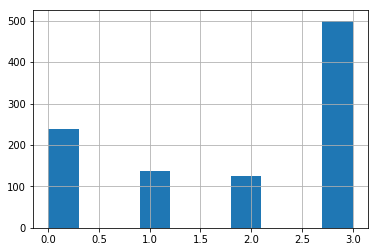

In [37]:
dist = Counter(train['accuracy_group'])
for k in dist:
    dist[k] /= len(train)

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')
sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].hist();